In [ ]:
# torch with cuda
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from ultralytics import YOLO
import torch
import os

# Load a model
model = YOLO("best.onnx")
# Change path to train dataset
path = os.path.join(os.path.abspath("."),"License Plate Recognition.v6i.yolov11.zip")

# Train the model
train_results = model.train(
    data=path,  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=640,  # training image size
    device="cuda" if torch.cuda.is_available() else "cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

# Evaluate model performance on the validation set
metrics = model.val()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model

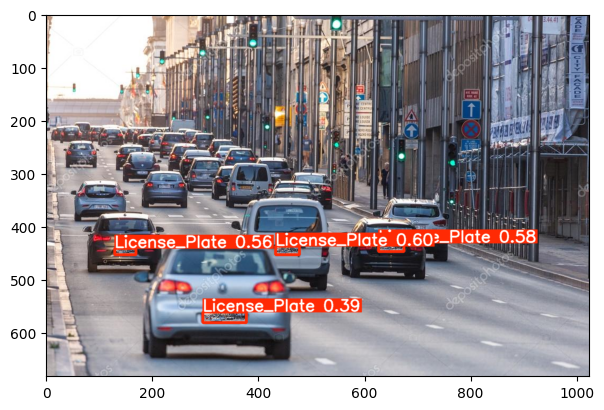

In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from matplotlib import pyplot as plt
from safe_video import ObjectDetection, filter_results, merge_results_list, apply_censorship, Censor
rec = ObjectDetection()

image = plt.imread("example.jpg")
licenseplates = rec.process_image(image, ["License_Plate"])
merged_licenseplates = merge_results_list(licenseplates)

filtered_licenseplates = filter_results(merged_licenseplates, "License_Plate", 0.3)
censored = apply_censorship(image, filtered_licenseplates, action=Censor.overlay, color=(120,21,132), overlayImage=image)

# to plot on censored image we can override the orig_img
filtered_licenseplates.orig_img = censored

# filters only for cars, after the the analysis
img_size = 7
plt.figure(figsize=(img_size,img_size))
plt.imshow(filtered_licenseplates.plot())
plt.show()
# plt.imsave("t.jpg", merged_licenseplates.plot())

In [ ]:
rec.get_names_with_classes()

In [ ]:
print(rec.get_classes())

### Adding models

In [ ]:
print(len(rec.get_classes()))
rec.add_model(os.path.join(os.path.abspath("."), "models", "face_recognition", "weights", "best.pt"))
print(len(rec.get_classes()))

In [ ]:
image = plt.imread("face_test.jpg")
faces = rec.process_image(image, "face")[0]

blur = apply_censorship(image, faces, overlayImage=plt.imread("example.jpg"), action=Censor.overlay)
faces.orig_img = blur
plt.figure(figsize=(img_size,img_size))
plt.imshow(faces.plot())
plt.show()

### Videos

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from safe_video import ObjectDetection, save_result_as_video
rec = ObjectDetection()

video = r"video1.mp4"
res = rec.process_video(video, [['car', 'bus'], 'License_Plate'], debug=True, verbose=False)

In [ ]:
# we can save the result now as a video and also apply censorship or filters. The sound is also copied to the output video
save_result_as_video(res, "output.mp4", original_video_path=video, class_filter="License_Plate", fps=30, censorship=Censor.blur, copy_audio=True)